# Travel Insurance Claim Prediction
### Capstone Project Module 3
---

## 1. Business Problem Understanding

### 1.1 Context

Asuransi perjalanan (*travel insurance*) adalah produk keuangan yang memberikan perlindungan terhadap risiko-risiko yang mungkin terjadi selama perjalanan, seperti:
- Pembatalan perjalanan
- Kehilangan bagasi
- Kecelakaan atau sakit selama perjalanan
- Evakuasi medis darurat

Industri asuransi perjalanan mengalami pertumbuhan pesat seiring dengan meningkatnya mobilitas global dan kesadaran masyarakat akan pentingnya perlindungan selama bepergian. Perusahaan asuransi perlu **memprediksi dengan akurat** apakah seorang pemegang polis akan mengajukan klaim atau tidak, agar dapat:

1. **Mengelola risiko finansial** dengan lebih baik
2. **Menentukan premi yang tepat** berdasarkan profil risiko
3. **Mengalokasikan cadangan dana klaim** secara efisien
4. **Mendeteksi potensi fraud** lebih dini

### 1.2 Problem Statement

Perusahaan asuransi perjalanan menghadapi tantangan dalam memprediksi klaim dari pemegang polis. Kesalahan prediksi dapat menyebabkan kerugian signifikan:

| Jenis Kesalahan | Deskripsi | Dampak Bisnis |
|-----------------|-----------|---------------|
| **False Positive (FP)** | Memprediksi akan klaim, tapi tidak klaim | Alokasi cadangan dana berlebihan, premi terlalu tinggi → kehilangan pelanggan |
| **False Negative (FN)** | Memprediksi tidak klaim, tapi ternyata klaim | Cadangan dana tidak cukup, kerugian finansial langsung, potensi kebangkrutan |

**Permasalahan utama:** Bagaimana memprediksi apakah seorang pemegang polis asuransi perjalanan akan mengajukan klaim atau tidak?

### 1.3 Goals

Berdasarkan permasalahan di atas, tujuan proyek ini adalah:

1. **Memahami karakteristik data** pemegang polis asuransi perjalanan
4. **Melakukan eksplorasi data** untuk menemukan pola dan insight
5. **Menyiapkan data** yang bersih untuk tahap modeling selanjutnya

### 1.4 Analytic Approach

Pendekatan yang akan digunakan:

1. **Data Cleansing**: Membersihkan data dari nilai yang tidak valid, missing values, dan anomali
2. **Exploratory Data Analysis (EDA)**: Menganalisis distribusi dan hubungan antar variabel
3. **Modeling** : Membangun model **klasifikasi biner** untuk memprediksi apakah pemegang polis akan mengajukan klaim (Yes) atau tidak (No)

### 1.5 Metric Evaluation

Karena dataset ini kemungkinan besar **imbalanced** (jumlah klaim jauh lebih sedikit dari non-klaim), kita perlu memilih metrik yang tepat.

**Analisis Error:**

| Error Type | Skenario | Konsekuensi Bisnis | Tingkat Bahaya |
|------------|----------|--------------------|-----------------|
| **Type I (FP)** | Prediksi: Klaim, Aktual: Tidak Klaim | Biaya operasional investigasi sia-sia, premi terlalu tinggi | ⚠️ Sedang |
| **Type II (FN)** | Prediksi: Tidak Klaim, Aktual: Klaim | Kerugian finansial langsung, cadangan dana tidak mencukupi | 🔴 Tinggi |

**Kesimpulan:**
> **False Negative lebih berbahaya** karena perusahaan akan mengalami kerugian finansial langsung. Oleh karena itu, kita perlu **memaksimalkan Recall** (kemampuan mendeteksi klaim yang sebenarnya).

**Rekomendasi Metrik:**
- **Primary:** Recall atau F2-Score (lebih menekankan Recall)
- **Secondary:** ROC-AUC untuk evaluasi keseluruhan
- **Monitoring:** Precision untuk memastikan tidak terlalu banyak false alarm

---
## 2. Data Understanding

In [ ]:
# Import Library yang dibutuhkan

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pengaturan tampilan
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print('Library berhasil diimport!')

Library berhasil diimport!


### 2.1 Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv('data_travel_insurance.csv')

# Tampilkan 5 baris pertama
print(f'Dataset berhasil dimuat dengan {df.shape[0]:,} baris dan {df.shape[1]} kolom')
df.head()

Dataset berhasil dimuat dengan 44,328 baris dan 11 kolom


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.00,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.00,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.00,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.00,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.00,4.00,28,No


### 2.2 Informasi Dataset

In [ ]:
# Informasi tipe data dan non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [ ]:
# Statistik deskriptif untuk kolom numerik
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.00,44328.00,44328.00,44328.00
mean,49.42,40.55,9.71,39.93
std,109.15,48.66,19.63,13.95
min,-1.00,-357.50,0.00,0.00
25%,9.00,18.00,0.00,35.00
50%,22.00,26.50,0.00,36.00
75%,53.00,48.00,11.55,43.00
max,4881.00,810.00,283.50,118.00


In [ ]:
# Statistik deskriptif untuk kolom kategorikal
df.describe(include='object')

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


### 2.3 Missing Values

In [ ]:
# Cek missing values
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
    'Data Type': df.dtypes.values
})

missing_df = missing_df.sort_values('Missing Percentage', ascending=False)
print('=== Missing Values Summary ===\n')
missing_df

=== Missing Values Summary ===



,Column,Missing Count,Missing Percentage,Data Type
4,Gender,31647,71.39,object
1,Agency Type,0,0.00,object
0,Agency,0,0.00,object
2,Distribution Channel,0,0.00,object
3,Product Name,0,0.00,object
5,Duration,0,0.00,int64
6,Destination,0,0.00,object
7,Net Sales,0,0.00,float64
8,Commision (in value),0,0.00,float64
9,Age,0,0.00,int64


### 2.4 Deskripsi Fitur

Berikut adalah penjelasan untuk setiap fitur dalam dataset:

| Fitur | Tipe | Deskripsi |
|-------|------|-----------|
| **Agency** | Kategorikal | Kode/nama agen yang menjual polis asuransi |
| **Agency Type** | Kategorikal | Tipe agen: Airlines (maskapai) atau Travel Agency (agen perjalanan) |
| **Distribution Channel** | Kategorikal | Saluran distribusi penjualan: Online atau Offline |
| **Product Name** | Kategorikal | Nama produk asuransi yang dibeli |
| **Gender** | Kategorikal | Jenis kelamin pemegang polis: M (Male), F (Female), atau kosong |
| **Duration** | Numerik | Durasi perjalanan dalam hari |
| **Destination** | Kategorikal | Negara tujuan perjalanan |
| **Net Sales** | Numerik | Pendapatan bersih dari penjualan polis |
| **Commision (in value)** | Numerik | Nilai komisi yang diberikan kepada agen |
| **Age** | Numerik | Usia pemegang polis |
| **Claim** | Kategorikal (Target) | Status klaim: Yes (mengajukan klaim) atau No (tidak klaim) |

In [ ]:
# Lihat unique values untuk setiap kolom kategorikal
categorical_cols = df.select_dtypes(include='object').columns

print('=== Unique Values per Kolom Kategorikal ===\n')
for col in categorical_cols:
    print(f'{col}: {df[col].nunique()} unique values')
    print(f'Sample: {df[col].unique()[:5]}\n')

=== Unique Values per Kolom Kategorikal ===

Agency: 16 unique values
Sample: ['C2B' 'EPX' 'JZI' 'CWT' 'LWC']

Agency Type: 2 unique values
Sample: ['Airlines' 'Travel Agency']

Distribution Channel: 2 unique values
Sample: ['Online' 'Offline']

Product Name: 26 unique values
Sample: ['Annual Silver Plan' 'Cancellation Plan' 'Basic Plan'
 '2 way Comprehensive Plan' 'Bronze Plan']

Gender: 2 unique values
Sample: ['F' nan 'M']

Destination: 138 unique values
Sample: ['SINGAPORE' 'MALAYSIA' 'INDIA' 'UNITED STATES' 'KOREA, REPUBLIC OF']

Claim: 2 unique values
Sample: ['No' 'Yes']



---
## 3. Data Cleansing

Pada tahap ini, kita akan membersihkan data dari anomali dan nilai yang tidak valid. Berdasarkan eksplorasi awal, terdapat beberapa masalah yang perlu ditangani:

1. **Age = 118**: Nilai usia yang tidak realistis
2. **Duration < 0**: Durasi perjalanan tidak mungkin negatif
3. **Gender missing**: Banyak nilai kosong pada kolom Gender
4. **Duplicate data**: Perlu dicek keberadaan data duplikat

### 3.1 Cek Data Duplikat

In [ ]:
# Cek jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f'Jumlah data duplikat: {duplicate_count:,}')
print(f'Persentase: {(duplicate_count/len(df)*100):.2f}%')

# Jika ada duplikat, tampilkan contohnya
if duplicate_count > 0:
    print('\nContoh data duplikat:')
    display(df[df.duplicated(keep=False)].head(10))

Jumlah data duplikat: 4,667
Persentase: 10.53%

Contoh data duplikat:


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.00,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.00,0.00,33,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.00,0.00,59,No
5,EPX,Travel Agency,Online,Cancellation Plan,NaN,2,SINGAPORE,10.00,0.00,36,No
31,EPX,Travel Agency,Online,Cancellation Plan,NaN,19,UNITED KINGDOM,10.00,0.00,36,No
33,C2B,Airlines,Online,Silver Plan,M,2,SINGAPORE,30.00,7.50,37,No
42,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,8,CHINA,48.00,0.00,36,No
43,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,13,MALAYSIA,29.70,17.82,27,No
67,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,29,SINGAPORE,20.00,0.00,36,No
69,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,55,HONG KONG,20.00,0.00,36,No


In [ ]:
# Simpan dataframe asli untuk perbandingan
df_original = df.copy()

# Hapus duplikat jika ada
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f'Data duplikat telah dihapus.')
    print(f'Jumlah baris sebelum: {len(df_original):,}')
    print(f'Jumlah baris setelah: {len(df):,}')
else:
    print('Tidak ada data duplikat yang perlu dihapus.')

Data duplikat telah dihapus.
Jumlah baris sebelum: 44,328
Jumlah baris setelah: 39,661


### 3.2 Handling Age Anomaly (Age = 118)

In [ ]:
# Cek distribusi Age
print('=== Distribusi Age ===\n')
print(df['Age'].describe())
print(f'\nNilai unik maksimum: {df["Age"].max()}')
print(f'Jumlah Age = 118: {(df["Age"] == 118).sum()}')

=== Distribusi Age ===

count   39661.00
mean       39.93
std        13.53
min         0.00
25%        34.00
50%        36.00
75%        45.00
max       118.00
Name: Age, dtype: float64

Nilai unik maksimum: 118
Jumlah Age = 118: 479


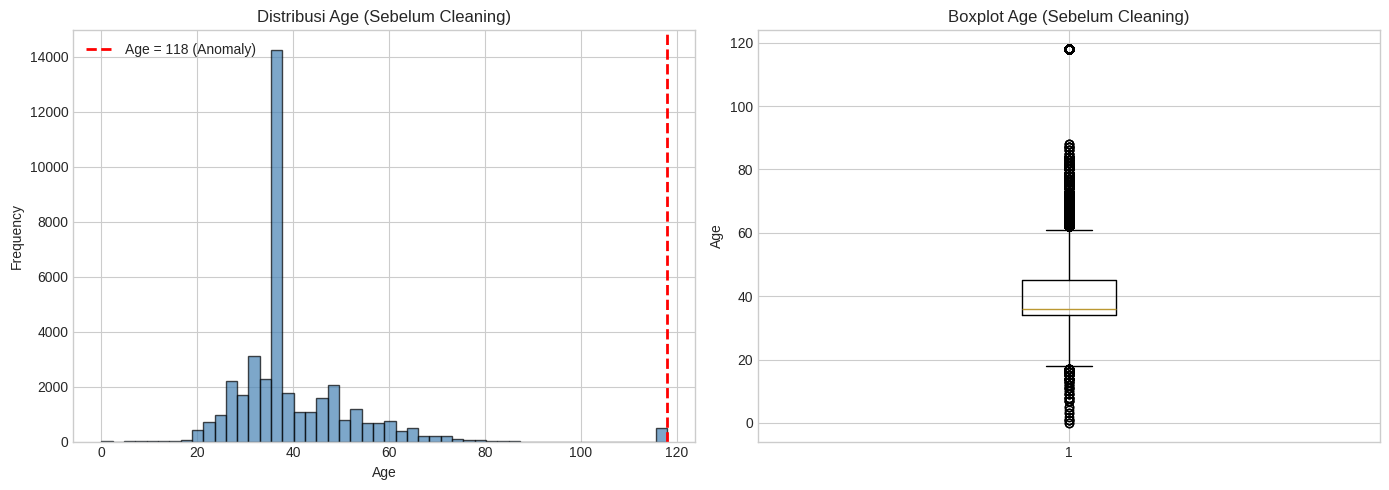

In [ ]:
# Visualisasi distribusi Age sebelum cleaning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Age'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=118, color='red', linestyle='--', linewidth=2, label='Age = 118 (Anomaly)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribusi Age (Sebelum Cleaning)')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['Age'], vert=True)
axes[1].set_ylabel('Age')
axes[1].set_title('Boxplot Age (Sebelum Cleaning)')

plt.tight_layout()
plt.show()

In [ ]:
# Hitung median Age (tanpa nilai 118)
median_age = df[df['Age'] != 118]['Age'].median()
print(f'Median Age (tanpa nilai 118): {median_age}')

# Ganti nilai Age = 118 dengan median
age_118_count_before = (df['Age'] == 118).sum()
df.loc[df['Age'] == 118, 'Age'] = median_age

print(f'\nJumlah Age = 118 sebelum: {age_118_count_before}')
print(f'Jumlah Age = 118 setelah: {(df["Age"] == 118).sum()}')
print(f'\nNilai Age = 118 telah diganti dengan median ({median_age})')

Median Age (tanpa nilai 118): 36.0

Jumlah Age = 118 sebelum: 479
Jumlah Age = 118 setelah: 0

Nilai Age = 118 telah diganti dengan median (36.0)


**Insight:**
> Nilai Age = 118 tidak realistis (sangat jarang orang berusia 118 tahun yang melakukan perjalanan). Kemungkinan ini adalah **placeholder** atau **data entry error**. Kita menggantinya dengan **median** usia karena median lebih robust terhadap outlier.

### 3.3 Handling Negative Duration

In [ ]:
# Cek Duration negatif
print('=== Distribusi Duration ===\n')
print(df['Duration'].describe())
print(f'\nNilai minimum: {df["Duration"].min()}')
print(f'Jumlah Duration < 0: {(df["Duration"] < 0).sum()}')
print(f'Jumlah Duration = 0: {(df["Duration"] == 0).sum()}')

=== Distribusi Duration ===

count   39661.00
mean       52.40
std       113.54
min        -1.00
25%        11.00
50%        25.00
75%        57.00
max      4881.00
Name: Duration, dtype: float64

Nilai minimum: -1
Jumlah Duration < 0: 2
Jumlah Duration = 0: 37


In [ ]:
# Lihat contoh data dengan Duration negatif
if (df['Duration'] < 0).sum() > 0:
    print('Contoh data dengan Duration negatif:')
    display(df[df['Duration'] < 0].head(10))

Contoh data dengan Duration negatif:


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
26228,JZI,Airlines,Online,Basic Plan,NaN,-1,MALAYSIA,18.00,6.30,36,No
26494,JZI,Airlines,Online,Basic Plan,NaN,-1,BRUNEI DARUSSALAM,18.00,6.30,36,No


In [ ]:
# Strategi: Ganti Duration negatif dengan nilai absolut
# Asumsi: Kemungkinan kesalahan input (tanda minus tidak sengaja)

negative_duration_count = (df['Duration'] < 0).sum()

if negative_duration_count > 0:
    # Ganti dengan nilai absolut
    df.loc[df['Duration'] < 0, 'Duration'] = df.loc[df['Duration'] < 0, 'Duration'].abs()
    print(f'✓ {negative_duration_count} data dengan Duration negatif telah diubah ke nilai absolut')
else:
    print('Tidak ada Duration negatif yang perlu diperbaiki.')

print(f'\nNilai minimum Duration setelah cleaning: {df["Duration"].min()}')

✓ 2 data dengan Duration negatif telah diubah ke nilai absolut

Nilai minimum Duration setelah cleaning: 0


**Insight:**
> Duration negatif tidak masuk akal karena durasi perjalanan tidak mungkin bernilai minus. Kemungkinan besar ini adalah **kesalahan input data**. Kita mengkonversinya ke nilai absolut dengan asumsi nilai sebenarnya adalah positif.

### 3.4 Handling Missing Gender Values

In [ ]:
# Cek missing values di kolom Gender
gender_missing = df['Gender'].isnull().sum()
gender_empty = (df['Gender'] == '').sum()

print('=== Missing Values di Gender ===\n')
print(f'Null values: {gender_missing}')
print(f'Empty string: {gender_empty}')
print(f'\nDistribusi Gender sebelum cleaning:')
print(df['Gender'].value_counts(dropna=False))

=== Missing Values di Gender ===

Null values: 27667
Empty string: 0

Distribusi Gender sebelum cleaning:
Gender
NaN    27667
M       6074
F       5920
Name: count, dtype: int64


In [ ]:
# Isi missing values dengan 'Unknown'
# Alasan: Tidak menghapus data karena jumlahnya cukup besar
#         'Unknown' lebih informatif daripada membiarkan kosong

df['Gender'] = df['Gender'].fillna('Unknown')
df['Gender'] = df['Gender'].replace('', 'Unknown')

print('Distribusi Gender setelah cleaning:')
print(df['Gender'].value_counts())

Distribusi Gender setelah cleaning:
Gender
Unknown    27667
M           6074
F           5920
Name: count, dtype: int64


**Insight:**
> Banyak data Gender yang kosong. Menghapus baris ini akan mengurangi dataset secara signifikan. Sebagai gantinya, kita mengisi dengan **'Unknown'** agar:
> 1. Tidak kehilangan banyak data
> 2. Model dapat mempelajari pola dari data tanpa informasi gender
> 3. Tetap transparan bahwa gender tidak diketahui (bukan di-impute sembarangan)

### 3.5 Ringkasan Data Cleansing

In [ ]:
# Ringkasan perubahan
print('=' * 50)
print('RINGKASAN DATA CLEANSING')
print('=' * 50)
print(f'\nJumlah baris awal: {len(df_original):,}')
print(f'Jumlah baris akhir: {len(df):,}')
print(f'Data yang dihapus: {len(df_original) - len(df):,}')
print(f'\nPerubahan yang dilakukan:')
print(f'  1. Duplikat dihapus: {duplicate_count:,} baris')
print(f'  2. Age = 118 diganti dengan median: {age_118_count_before:,} baris')
print(f'  3. Duration negatif diubah ke absolut: {negative_duration_count:,} baris')
print(f'  4. Gender kosong diisi dengan "Unknown"')
print('\n' + '=' * 50)

RINGKASAN DATA CLEANSING

Jumlah baris awal: 44,328
Jumlah baris akhir: 39,661
Data yang dihapus: 4,667

Perubahan yang dilakukan:
  1. Duplikat dihapus: 4,667 baris
  2. Age = 118 diganti dengan median: 479 baris
  3. Duration negatif diubah ke absolut: 2 baris
  4. Gender kosong diisi dengan "Unknown"



In [ ]:
# Verifikasi data sudah bersih
print('=== Verifikasi Data Setelah Cleaning ===\n')
print(f'Age = 118: {(df["Age"] == 118).sum()} (seharusnya 0)')
print(f'Duration < 0: {(df["Duration"] < 0).sum()} (seharusnya 0)')
print(f'Gender missing: {df["Gender"].isnull().sum()} (seharusnya 0)')
print(f'Duplikat: {df.duplicated().sum()} (seharusnya 0)')

=== Verifikasi Data Setelah Cleaning ===

Age = 118: 0 (seharusnya 0)
Duration < 0: 0 (seharusnya 0)
Gender missing: 0 (seharusnya 0)
Duplikat: 1 (seharusnya 0)


---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribusi Target (Claim)

In [ ]:
# Hitung proporsi Claim
claim_counts = df['Claim'].value_counts()
claim_percentage = df['Claim'].value_counts(normalize=True) * 100

print('=== Distribusi Target (Claim) ===\n')
print(f'No (Tidak Klaim): {claim_counts["No"]:,} ({claim_percentage["No"]:.2f}%)')
print(f'Yes (Klaim): {claim_counts["Yes"]:,} ({claim_percentage["Yes"]:.2f}%)')
print(f'\nRasio No:Yes = {claim_counts["No"]/claim_counts["Yes"]:.1f}:1')

=== Distribusi Target (Claim) ===

No (Tidak Klaim): 38,986 (98.30%)
Yes (Klaim): 675 (1.70%)

Rasio No:Yes = 57.8:1


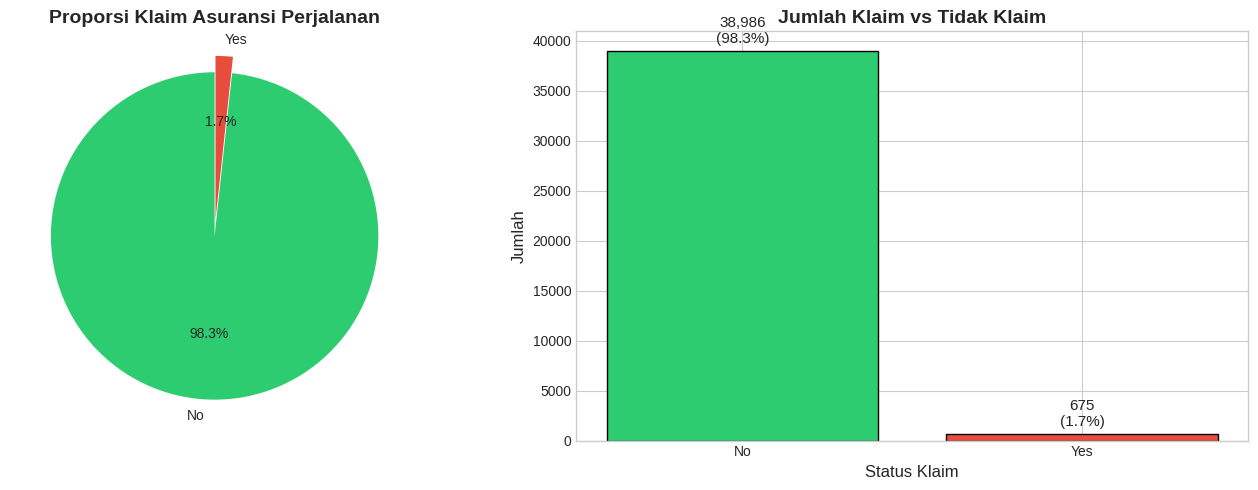

In [ ]:
# Visualisasi proporsi Claim
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Warna custom
colors = ['#2ecc71', '#e74c3c']  # Hijau untuk No, Merah untuk Yes

# Pie Chart
axes[0].pie(claim_counts.values, labels=claim_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0, 0.1])
axes[0].set_title('Proporsi Klaim Asuransi Perjalanan', fontsize=14, fontweight='bold')

# Bar Chart
bars = axes[1].bar(claim_counts.index, claim_counts.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Status Klaim', fontsize=12)
axes[1].set_ylabel('Jumlah', fontsize=12)
axes[1].set_title('Jumlah Klaim vs Tidak Klaim', fontsize=14, fontweight='bold')

# Tambahkan label di atas bar
for bar, count, pct in zip(bars, claim_counts.values, claim_percentage.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                 f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

**Insight:**
> - Dataset menunjukkan **imbalance yang signifikan** dengan mayoritas pemegang polis tidak mengajukan klaim.
> - Rasio yang tidak seimbang ini perlu ditangani pada tahap modeling dengan teknik seperti:
>   - SMOTE (Synthetic Minority Over-sampling Technique)
>   - Class weight adjustment
>   - Undersampling majority class
> - Metric seperti **Accuracy tidak cocok** untuk data imbalanced ini. Gunakan **Recall, F1-Score, atau ROC-AUC**.

### 4.2 Analisis Agency terhadap Claim

In [ ]:
# Analisis Agency vs Claim
agency_claim = pd.crosstab(df['Agency'], df['Claim'], normalize='index') * 100
agency_claim['Total'] = df.groupby('Agency').size()
agency_claim = agency_claim.sort_values('Yes', ascending=False)

print('=== Claim Rate per Agency (Top 10) ===\n')
agency_claim.head(10)

=== Claim Rate per Agency (Top 10) ===



Claim,No,Yes,Total
Agency,,,
C2B,92.63,7.37,5493
LWC,93.60,6.40,453
KML,97.99,2.01,249
CCR,98.31,1.69,118
TTW,98.48,1.52,66
CSR,98.53,1.47,68
CBH,98.55,1.45,69
JWT,98.81,1.19,337
CWT,98.88,1.12,5726


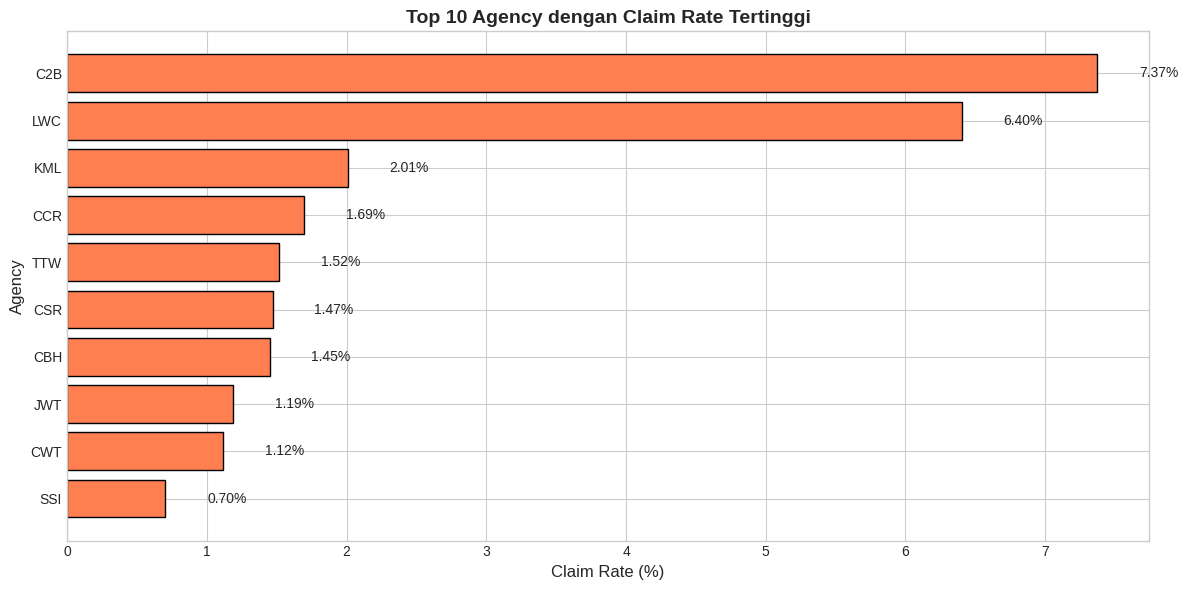

In [ ]:
# Visualisasi Top 10 Agency dengan Claim Rate tertinggi
top_agencies = agency_claim.head(10)

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax.barh(top_agencies.index, top_agencies['Yes'], color='coral', edgecolor='black')

# Tambahkan label
for bar, rate in zip(bars, top_agencies['Yes']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{rate:.2f}%', ha='left', va='center', fontsize=10)

ax.set_xlabel('Claim Rate (%)', fontsize=12)
ax.set_ylabel('Agency', fontsize=12)
ax.set_title('Top 10 Agency dengan Claim Rate Tertinggi', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Agar agency tertinggi di atas

plt.tight_layout()
plt.show()

In [ ]:
# Analisis berdasarkan Agency Type
agency_type_claim = pd.crosstab(df['Agency Type'], df['Claim'], normalize='index') * 100

print('=== Claim Rate per Agency Type ===\n')
print(agency_type_claim.round(2))

=== Claim Rate per Agency Type ===

Claim            No  Yes
Agency Type             
Airlines      96.21 3.79
Travel Agency 99.15 0.85


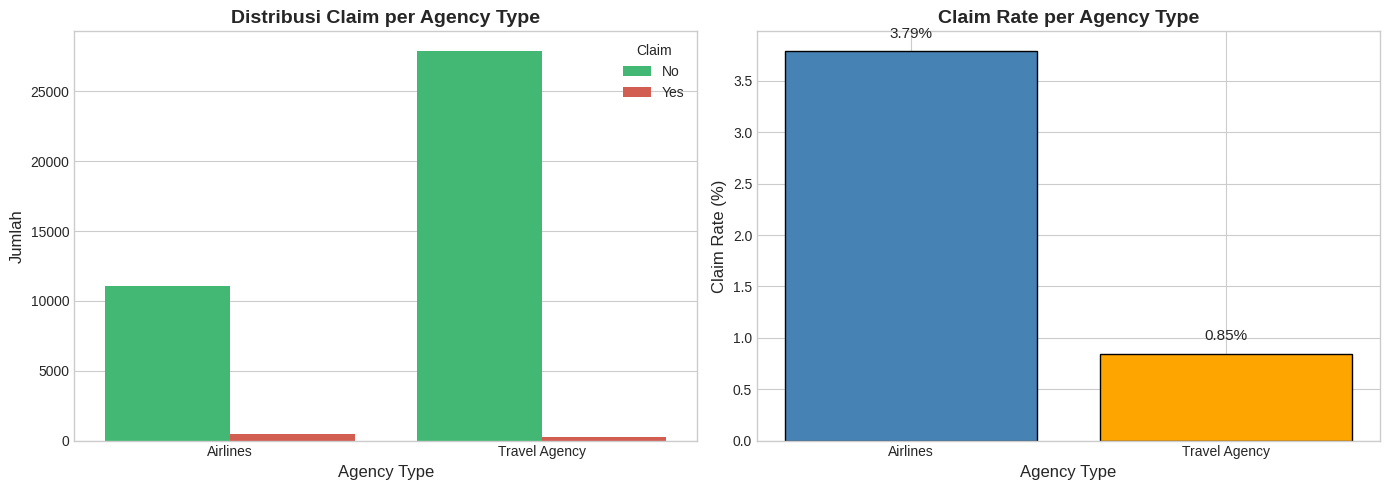

In [ ]:
# Visualisasi Agency Type vs Claim
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
sns.countplot(data=df, x='Agency Type', hue='Claim', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribusi Claim per Agency Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Agency Type', fontsize=12)
axes[0].set_ylabel('Jumlah', fontsize=12)
axes[0].legend(title='Claim')

# Claim Rate
x = agency_type_claim.index
bars = axes[1].bar(x, agency_type_claim['Yes'], color=['steelblue', 'orange'], edgecolor='black')
axes[1].set_title('Claim Rate per Agency Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Agency Type', fontsize=12)
axes[1].set_ylabel('Claim Rate (%)', fontsize=12)

# Label
for bar, rate in zip(bars, agency_type_claim['Yes']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{rate:.2f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

**Insight:**
> - Terdapat variasi claim rate yang cukup signifikan antar agency
> - Beberapa agency memiliki claim rate yang jauh lebih tinggi dari rata-rata
> - **Agency Type** kemungkinan merupakan fitur penting:
>   - Airlines cenderung memiliki claim rate yang berbeda dengan Travel Agency
>   - Ini bisa disebabkan oleh perbedaan jenis produk yang dijual atau profil pelanggan

### 4.3 Analisis Product Name terhadap Claim

In [ ]:
# Analisis Product Name vs Claim
product_claim = pd.crosstab(df['Product Name'], df['Claim'], normalize='index') * 100
product_claim['Total'] = df.groupby('Product Name').size()
product_claim = product_claim.sort_values('Yes', ascending=False)

print('=== Claim Rate per Product Name ===\n')
product_claim

=== Claim Rate per Product Name ===



Claim,No,Yes,Total
Product Name,,,
Annual Silver Plan,87.96,12.04,897
Annual Gold Plan,88.41,11.59,138
Annual Travel Protect Gold,88.89,11.11,63
Single Trip Travel Protect Platinum,89.36,10.64,47
Spouse or Parents Comprehensive Plan,92.31,7.69,13
Silver Plan,92.82,7.18,1504
Annual Travel Protect Silver,93.22,6.78,59
Bronze Plan,94.08,5.92,2718
Annual Travel Protect Platinum,94.12,5.88,34


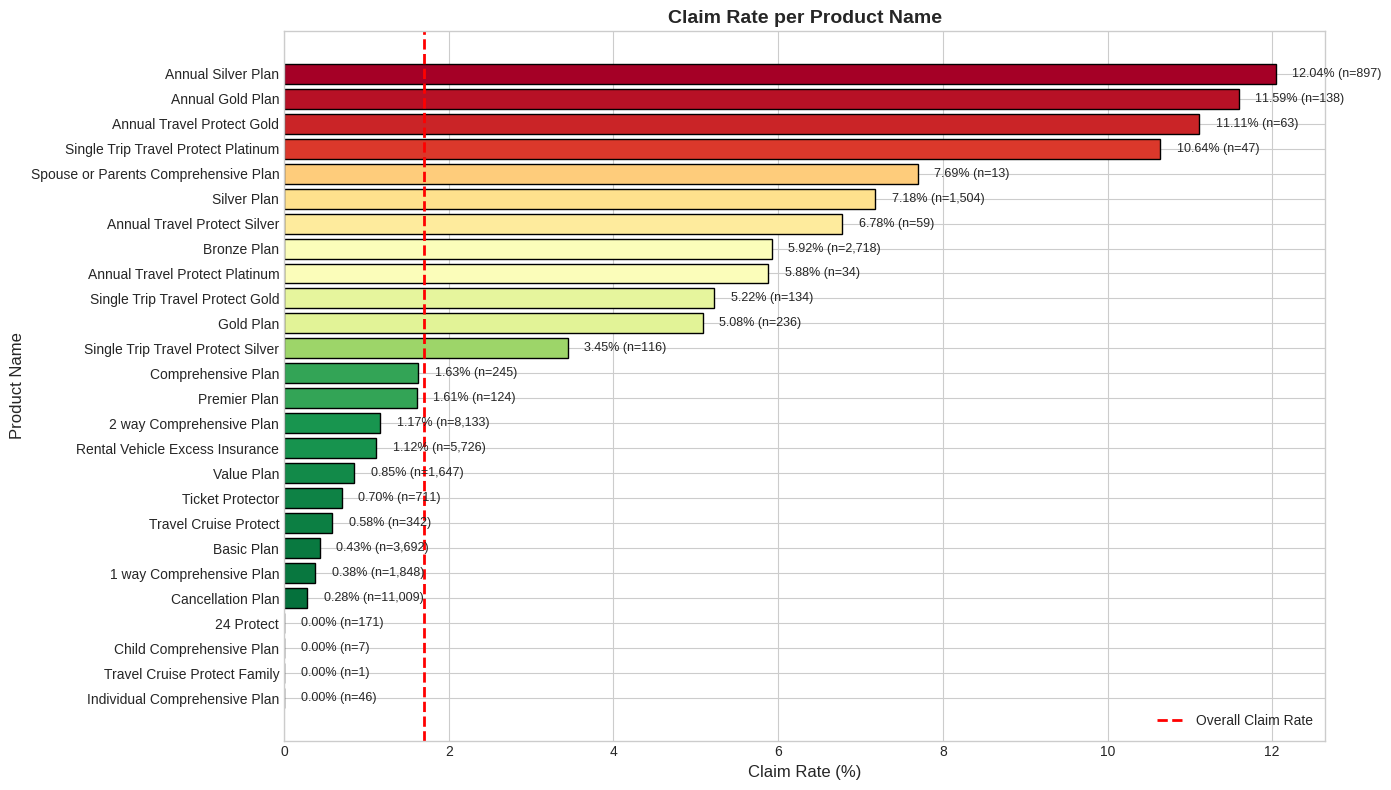

In [ ]:
# Visualisasi Semua Product dengan Claim Rate
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by claim rate
product_sorted = product_claim.sort_values('Yes', ascending=True)

# Bar chart horizontal
colors = plt.cm.RdYlGn_r(product_sorted['Yes'] / product_sorted['Yes'].max())
bars = ax.barh(product_sorted.index, product_sorted['Yes'], color=colors, edgecolor='black')

# Tambahkan label
for bar, rate, total in zip(bars, product_sorted['Yes'], product_sorted['Total']):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
            f'{rate:.2f}% (n={total:,})', ha='left', va='center', fontsize=9)

ax.set_xlabel('Claim Rate (%)', fontsize=12)
ax.set_ylabel('Product Name', fontsize=12)
ax.set_title('Claim Rate per Product Name', fontsize=14, fontweight='bold')
ax.axvline(x=df['Claim'].value_counts(normalize=True)['Yes']*100,
           color='red', linestyle='--', linewidth=2, label='Overall Claim Rate')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Top 5 produk dengan claim rate tertinggi
print('=== Top 5 Produk dengan Claim Rate Tertinggi ===\n')
for i, (product, row) in enumerate(product_claim.head(5).iterrows(), 1):
    print(f'{i}. {product}')
    print(f'   Claim Rate: {row["Yes"]:.2f}%')
    print(f'   Total Polis: {int(row["Total"]):,}\n')

=== Top 5 Produk dengan Claim Rate Tertinggi ===

1. Annual Silver Plan
   Claim Rate: 12.04%
   Total Polis: 897

2. Annual Gold Plan
   Claim Rate: 11.59%
   Total Polis: 138

3. Annual Travel Protect Gold
   Claim Rate: 11.11%
   Total Polis: 63

4. Single Trip Travel Protect Platinum
   Claim Rate: 10.64%
   Total Polis: 47

5. Spouse or Parents Comprehensive Plan
   Claim Rate: 7.69%
   Total Polis: 13



**Insight:**
> - Terdapat perbedaan claim rate yang sangat besar antar produk asuransi
> - Beberapa produk memiliki claim rate yang jauh di atas rata-rata:
>   - Produk dengan coverage lebih komprehensif cenderung memiliki claim rate lebih tinggi
>   - Ini bisa jadi karena pemegang polis lebih aware untuk mengklaim
> - **Product Name adalah fitur yang sangat penting** untuk prediksi klaim
> - Produk dengan claim rate rendah mungkin:
>   - Memiliki cakupan terbatas
>   - Dijual ke segmen pelanggan yang berbeda
>   - Memiliki proses klaim yang lebih sulit

### 4.4 Analisis Tambahan: Numerik Features vs Claim

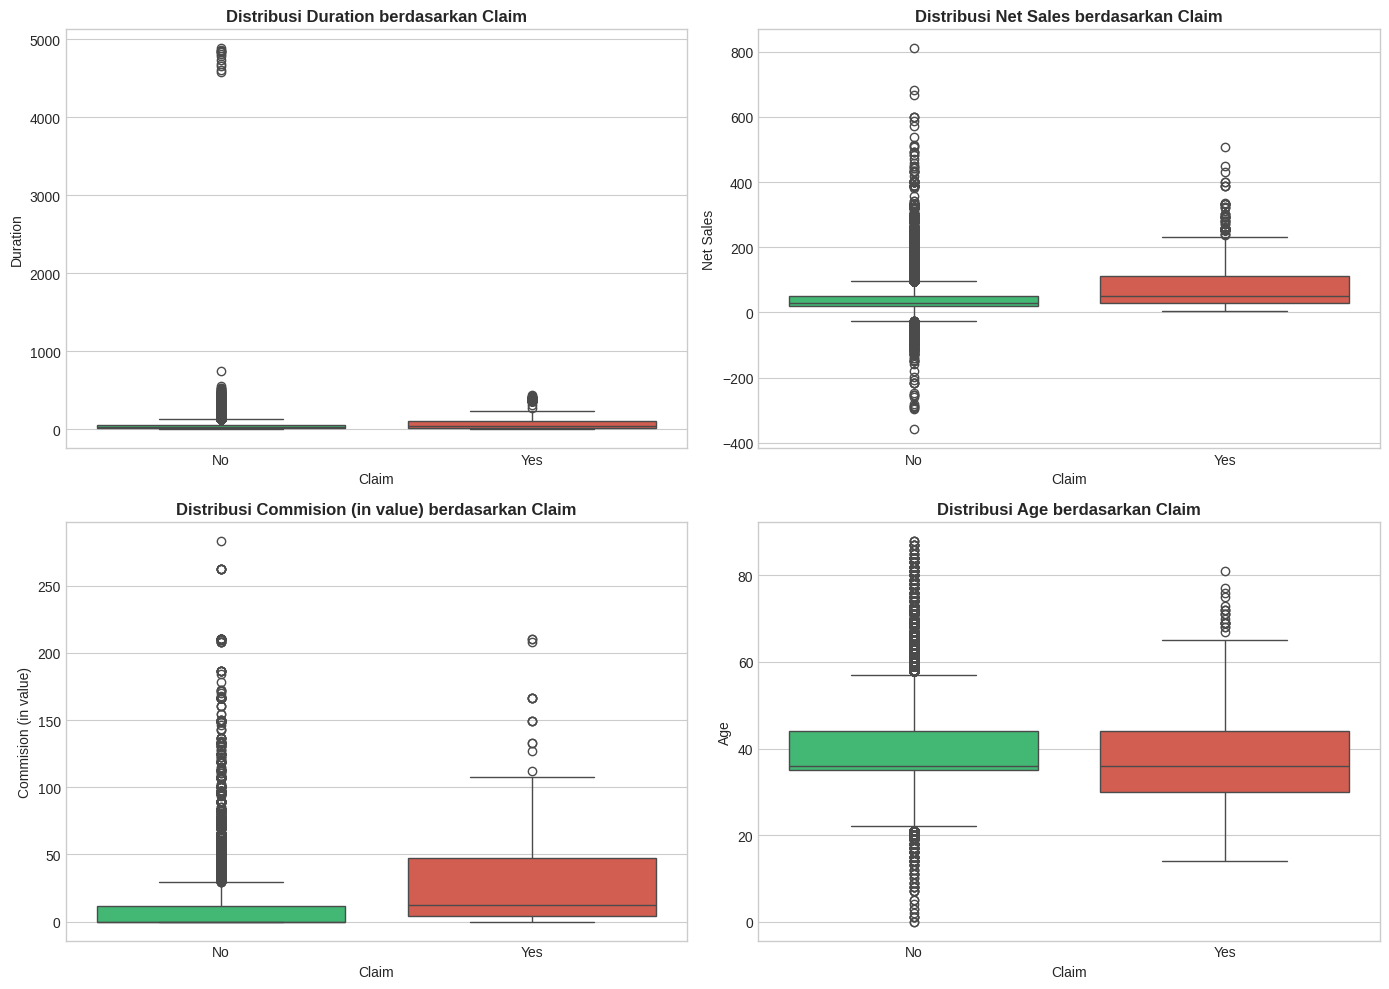

In [ ]:
# Distribusi fitur numerik berdasarkan Claim
numerical_cols = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Claim', y=col, ax=axes[i], palette=['#2ecc71', '#e74c3c'])
    axes[i].set_title(f'Distribusi {col} berdasarkan Claim', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Claim', fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Statistik numerik berdasarkan Claim
print('=== Statistik Numerik berdasarkan Status Klaim ===\n')
print(df.groupby('Claim')[numerical_cols].mean().round(2))

=== Statistik Numerik berdasarkan Status Klaim ===

       Duration  Net Sales  Commision (in value)   Age
Claim                                                 
No        51.46      41.46                 10.17 38.96
Yes      106.54      93.50                 25.91 37.72


**Insight:**
> - **Duration**: Pemegang polis yang mengklaim cenderung memiliki durasi perjalanan yang lebih panjang
> - **Net Sales & Commission**: Tidak terlihat perbedaan signifikan antara yang klaim dan tidak
> - **Age**: Distribusi usia relatif serupa untuk kedua grup

---
## 5. Kesimpulan & Rekomendasi

### 5.1 Ringkasan Temuan

**Data Cleansing:**
1. ✅ Data duplikat telah dicek dan dihapus (jika ada)
2. ✅ Anomali Age = 118 telah diganti dengan median
3. ✅ Duration negatif telah diubah ke nilai absolut
4. ✅ Missing values Gender diisi dengan 'Unknown'

**EDA Findings:**
1. **Imbalanced Dataset**: Mayoritas pemegang polis tidak mengajukan klaim (rasio tidak seimbang)
2. **Agency**: Beberapa agency memiliki claim rate yang jauh lebih tinggi dari rata-rata
3. **Product Name**: Faktor yang sangat mempengaruhi kemungkinan klaim
4. **Duration**: Perjalanan lebih panjang cenderung memiliki claim rate lebih tinggi

### 5.2 Rekomendasi untuk Modeling

1. **Handling Imbalance**:
   - Gunakan SMOTE, RandomOverSampler, atau class_weight
   - Jangan gunakan Accuracy sebagai metric utama

2. **Feature Engineering**:
   - One-Hot atau Label Encoding untuk fitur kategorikal
   - Pertimbangkan binning untuk Duration dan Age

3. **Metric**:
   - Gunakan Recall atau F2-Score sebagai metric utama (minimize False Negative)
   - Monitor Precision untuk menghindari terlalu banyak false alarm

4. **Model Candidates**:
   - Logistic Regression (baseline)
   - Random Forest
   - XGBoost/LightGBM
   - Ensemble methods

In [ ]:
# Simpan data yang sudah dibersihkan (opsional)
# df.to_csv('data_travel_insurance_cleaned.csv', index=False)
# print('Data bersih telah disimpan ke: data_travel_insurance_cleaned.csv')

print('=' * 50)
print('NOTEBOOK SELESAI')
print('Data siap untuk tahap Feature Engineering & Modeling')
print('=' * 50)

NOTEBOOK SELESAI
Data siap untuk tahap Feature Engineering & Modeling


---
# Modeling
---

In [ ]:
# === Import Library Tambahan untuk Modeling ===

# Install missing library
!pip install category_encoders

import warnings, json, pickle, time
from datetime import datetime

# Sklearn
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_auc_score, roc_curve, make_scorer, fbeta_score,
    precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# External
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import category_encoders as ce
import shap

warnings.filterwarnings('ignore')

print('✓ Library tambahan untuk modeling berhasil diimport!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.7 MB/s eta 0:00:00
✓ Library tambahan untuk modeling berhasil diimport!


### 1.2 Encode Target Variable

In [ ]:
# Encode Claim: Yes → 1, No → 0
le = LabelEncoder()
df['Claim'] = le.fit_transform(df['Claim'])  # No=0, Yes=1
print('Mapping:', dict(zip(le.classes_, le.transform(le.classes_))))
print(f'\nDistribusi target:\n{df["Claim"].value_counts()}')

Mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

Distribusi target:
Claim
0    38986
1      675
Name: count, dtype: int64


### 1.3 Feature EngineeringKita membuat beberapa fitur baru untuk meningkatkan kemampuan prediksi model:| Fitur Baru | Logika | Alasan Bisnis ||------------|--------|---------------|| `Is_Senior` | 1 jika Age > 60 | Senior traveler cenderung memiliki risiko kesehatan lebih tinggi || `Trip_Type` | Short (≤7), Medium (8–30), Long (>30) | Durasi perjalanan panjang meningkatkan eksposur risiko || `Sales_Per_Day` | Net Sales / Duration | Mengukur 'intensitas' perlindungan per hari perjalanan |

In [ ]:
# Feature Engineering
df['Is_Senior'] = (df['Age'] > 60).astype(int)

def categorize_trip(duration):
    if duration <= 7:
        return 'Short'
    elif duration <= 30:
        return 'Medium'
    else:
        return 'Long'

df['Trip_Type'] = df['Duration'].apply(categorize_trip)

# Sales_Per_Day (handle Duration = 0)
df['Sales_Per_Day'] = np.where(
    df['Duration'] > 0,
    df['Net Sales'] / df['Duration'],
    df['Net Sales']  # Jika Duration = 0, gunakan Net Sales langsung
)

print('Fitur baru berhasil dibuat!')
print(f'Kolom: {list(df.columns)}')
df[['Age', 'Is_Senior', 'Duration', 'Trip_Type', 'Net Sales', 'Sales_Per_Day']].head(10)

Fitur baru berhasil dibuat!
Kolom: ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Gender', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age', 'Claim', 'Is_Senior', 'Trip_Type', 'Sales_Per_Day']


,Age,Is_Senior,Duration,Trip_Type,Net Sales,Sales_Per_Day
0,57,0,365,Long,216.00,0.59
1,33,0,4,Short,10.00,2.50
2,26,0,19,Medium,22.00,1.16
3,59,0,20,Medium,112.00,5.60
4,28,0,8,Medium,16.00,2.00
5,36,0,2,Short,10.00,5.00
6,36,0,25,Medium,50.00,2.00
7,22,0,90,Long,78.00,0.87
8,39,0,4,Short,22.00,5.50
9,36,0,24,Medium,80.00,3.33


### 1.4 Train-Test Split

In [ ]:
# Pisahkan fitur dan target
X = df.drop('Claim', axis=1)
y = df['Claim']

# Train-Test Split (80:20, stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {X_train.shape[0]:,} baris')
print(f'Test set    : {X_test.shape[0]:,} baris')
print(f'\nDistribusi target (train):\n{y_train.value_counts(normalize=True).round(4)}')
print(f'\nDistribusi target (test):\n{y_test.value_counts(normalize=True).round(4)}')

Training set: 31,728 baris
Test set    : 7,933 baris

Distribusi target (train):
Claim
0   0.98
1   0.02
Name: proportion, dtype: float64

Distribusi target (test):
Claim
0   0.98
1   0.02
Name: proportion, dtype: float64


---## 2. Preprocessing PipelineKita menggunakan `ColumnTransformer` untuk menangani fitur numerik dan kategorikal secara berbeda, dikombinasikan dengan `imblearn.pipeline.Pipeline` agar teknik resampling bisa diintegrasikan.

In [ ]:
# Definisi kolom
num_features = ['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Sales_Per_Day']
cat_low_features = ['Agency Type', 'Distribution Channel', 'Gender', 'Trip_Type']
cat_high_features = ['Agency', 'Product Name', 'Destination']

print('Numerical features      :', num_features)
print('Low-cardinality cat     :', cat_low_features)
print('High-cardinality cat    :', cat_high_features)
print(f'\nTotal fitur yang digunakan: {len(num_features) + len(cat_low_features) + len(cat_high_features)}')

Numerical features      : ['Duration', 'Net Sales', 'Commision (in value)', 'Age', 'Sales_Per_Day']
Low-cardinality cat     : ['Agency Type', 'Distribution Channel', 'Gender', 'Trip_Type']
High-cardinality cat    : ['Agency', 'Product Name', 'Destination']

Total fitur yang digunakan: 12


In [ ]:
# Preprocessing Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features),
        ('cat_low', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_low_features),
        ('cat_high', ce.TargetEncoder(cols=cat_high_features, smoothing=1.0), cat_high_features)
    ],
    remainder='drop'
)

print('✓ Preprocessor berhasil dibuat!')
print('  - Numerical   → RobustScaler')
print('  - Low-card cat → OneHotEncoder')
print('  - High-card cat→ TargetEncoder')

✓ Preprocessor berhasil dibuat!
  - Numerical   → RobustScaler
  - Low-card cat → OneHotEncoder
  - High-card cat→ TargetEncoder


---## 3. Model BenchmarkingKita menguji **6 model** klasifikasi secara bersamaan menggunakan **F2-Score** sebagai metrik utama.$$F_\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}$$Dengan β=2, Recall mendapat bobot **4× lebih besar** dari Precision — cocok untuk kasus di mana False Negative lebih berbahaya.

In [ ]:
# F2-Score custom scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Definisi model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False,
                              eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Benchmark tanpa resampling
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
benchmark_results = []

print('=== Model Benchmarking (tanpa resampling) ===')
print(f'{"Model":<25} {"F2-Score (mean ± std)":<25}')
print('-' * 50)

for name, model in models.items():
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    benchmark_results.append({
        'Model': name,
        'F2_mean': scores.mean(),
        'F2_std': scores.std()
    })
    print(f'{name:<25} {scores.mean():.4f} ± {scores.std():.4f}')

benchmark_df = pd.DataFrame(benchmark_results).sort_values('F2_mean', ascending=False)
print('\n✓ Benchmarking selesai!')

=== Model Benchmarking (tanpa resampling) ===
Model                     F2-Score (mean ± std)    
--------------------------------------------------
Logistic Regression       0.0000 ± 0.0000
Decision Tree             0.0646 ± 0.0164
Random Forest             0.0110 ± 0.0139
XGBoost                   0.0114 ± 0.0072
LightGBM                  0.0023 ± 0.0046
Gradient Boosting         0.0023 ± 0.0045

✓ Benchmarking selesai!


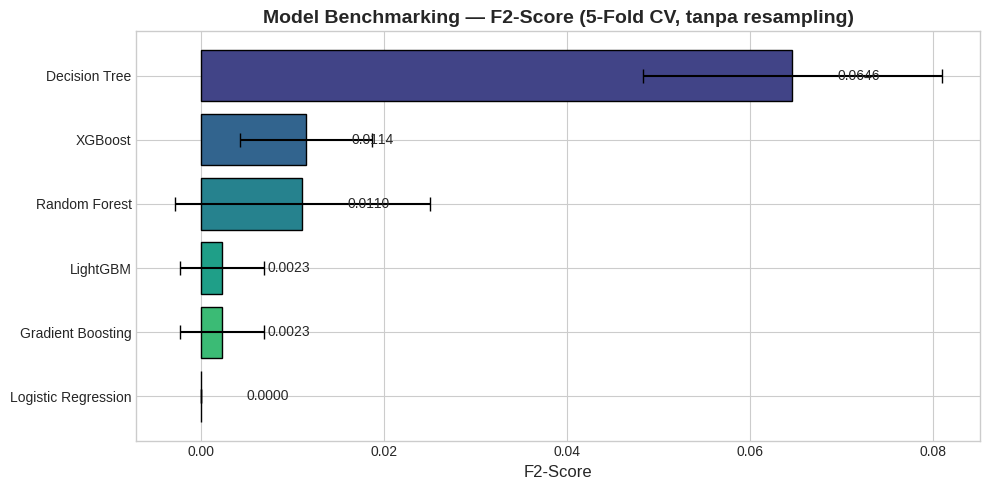

In [ ]:
# Visualisasi benchmark
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(benchmark_df)))
bars = ax.barh(benchmark_df['Model'], benchmark_df['F2_mean'], xerr=benchmark_df['F2_std'],
               color=colors, edgecolor='black', capsize=5)
ax.set_xlabel('F2-Score', fontsize=12)
ax.set_title('Model Benchmarking — F2-Score (5-Fold CV, tanpa resampling)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, benchmark_df['F2_mean']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=10)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---## 4. Handling Class Imbalance (Experimental)Kita membandingkan **3 teknik resampling** pada setiap model:- **RandomOverSampler** — duplikasi sampel minoritas secara acak- **SMOTE** — membuat sampel sintetis berdasarkan nearest neighbors- **ADASYN** — mirip SMOTE tapi fokus pada sampel yang sulit diklasifikasi

In [ ]:
# Definisi teknik resampling
resamplers = {
    'No Resampling': None,
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

# Eksperimen: setiap model × setiap teknik
experiment_results = []

print('=== Eksperimen Imbalance Handling ===')
print('Mohon tunggu, proses ini memerlukan waktu...\n')

for model_name, model in models.items():
    for resamp_name, resampler in resamplers.items():
        steps = [('preprocessor', preprocessor)]
        if resampler is not None:
            steps.append(('resampler', resampler))
        steps.append(('classifier', model))
        pipe = ImbPipeline(steps)

        try:
            scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
            experiment_results.append({
                'Model': model_name,
                'Resampling': resamp_name,
                'F2_mean': scores.mean(),
                'F2_std': scores.std()
            })
            print(f'  {model_name:<25} + {resamp_name:<20} → F2 = {scores.mean():.4f} ± {scores.std():.4f}')
        except Exception as e:
            print(f'  {model_name:<25} + {resamp_name:<20} → ERROR: {e}')

exp_df = pd.DataFrame(experiment_results).sort_values('F2_mean', ascending=False)
print('\n✓ Eksperimen selesai!')

=== Eksperimen Imbalance Handling ===
Mohon tunggu, proses ini memerlukan waktu...

  Logistic Regression       + No Resampling        → F2 = 0.0000 ± 0.0000
  Logistic Regression       + RandomOverSampler    → F2 = 0.2317 ± 0.0133
  Logistic Regression       + SMOTE                → F2 = 0.2376 ± 0.0110
  Logistic Regression       + ADASYN               → F2 = 0.2343 ± 0.0113
  Decision Tree             + No Resampling        → F2 = 0.0646 ± 0.0164
  Decision Tree             + RandomOverSampler    → F2 = 0.0447 ± 0.0212
  Decision Tree             + SMOTE                → F2 = 0.1109 ± 0.0238
  Decision Tree             + ADASYN               → F2 = 0.1045 ± 0.0256
  Random Forest             + No Resampling        → F2 = 0.0110 ± 0.0139
  Random Forest             + RandomOverSampler    → F2 = 0.0392 ± 0.0238
  Random Forest             + SMOTE                → F2 = 0.0911 ± 0.0416
  Random Forest             + ADASYN               → F2 = 0.0890 ± 0.0411
  XGBoost                   

In [ ]:
# Tabel ranking
print('=== Top 10 Kombinasi (Model + Resampling) ===')
exp_df.head(10).reset_index(drop=True)

=== Top 10 Kombinasi (Model + Resampling) ===


,Model,Resampling,F2_mean,F2_std
0,Logistic Regression,SMOTE,0.24,0.01
1,Logistic Regression,ADASYN,0.23,0.01
2,Logistic Regression,RandomOverSampler,0.23,0.01
3,Gradient Boosting,SMOTE,0.23,0.01
4,Gradient Boosting,ADASYN,0.22,0.02
5,LightGBM,RandomOverSampler,0.21,0.02
6,Gradient Boosting,RandomOverSampler,0.21,0.01
7,XGBoost,RandomOverSampler,0.17,0.03
8,LightGBM,ADASYN,0.15,0.03
9,LightGBM,SMOTE,0.15,0.03


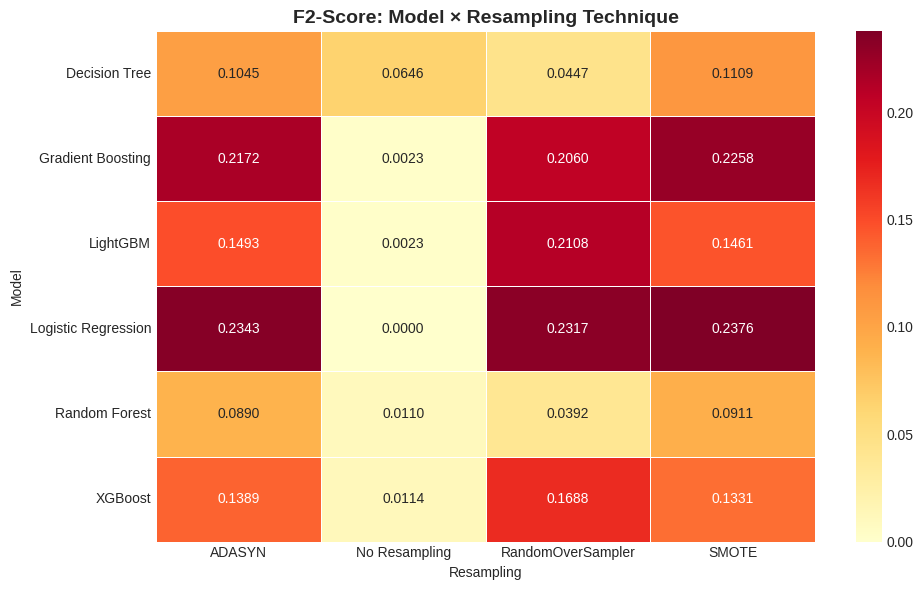

In [ ]:
# Heatmap perbandingan
pivot = exp_df.pivot(index='Model', columns='Resampling', values='F2_mean')
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('F2-Score: Model × Resampling Technique', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---## 5. Hyperparameter TuningBerdasarkan eksperimen di atas, kita memilih **kombinasi terbaik** dan melakukan `RandomizedSearchCV` dengan **100 iterasi** untuk mengoptimasi F2-Score.

In [ ]:
# Pilih kombinasi terbaik
best_row = exp_df.iloc[0]
best_model_name = best_row['Model']
best_resamp_name = best_row['Resampling']
print(f'Kombinasi terbaik: {best_model_name} + {best_resamp_name}')
print(f'F2-Score: {best_row["F2_mean"]:.4f} ± {best_row["F2_std"]:.4f}')

Kombinasi terbaik: Logistic Regression + SMOTE
F2-Score: 0.2376 ± 0.0110


In [ ]:
# Hyperparameter search space (adaptif berdasarkan model terbaik)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 5],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__reg_alpha': [0, 0.01, 0.1, 1],
        'classifier__reg_lambda': [0, 0.01, 0.1, 1]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [3, 5, 7, 10, -1],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__num_leaves': [15, 31, 63, 127],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 5]
    }
}

param_grid = param_grids[best_model_name]
print(f'Search space untuk {best_model_name}:')
for k, v in param_grid.items():
    print(f'  {k}: {v}')

Search space untuk Logistic Regression:
  classifier__C: [0.001, 0.01, 0.1, 1, 10, 100]
  classifier__penalty: ['l1', 'l2']
  classifier__solver: ['liblinear', 'saga']


In [ ]:
# Build pipeline untuk tuning
steps = [('preprocessor', preprocessor)]
best_resampler = resamplers[best_resamp_name]
if best_resampler is not None:
    steps.append(('resampler', best_resampler))
steps.append(('classifier', models[best_model_name]))
tune_pipe = ImbPipeline(steps)

# RandomizedSearchCV
print(f'Memulai RandomizedSearchCV (100 iterasi)...')
start = time.time()

search = RandomizedSearchCV(
    tune_pipe,
    param_distributions=param_grid,
    n_iter=100,
    cv=cv,
    scoring=f2_scorer,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)

elapsed = time.time() - start
print(f'\n✓ Tuning selesai dalam {elapsed:.1f} detik')
print(f'Best F2-Score (CV): {search.best_score_:.4f}')
print(f'Best params: {search.best_params_}')

Memulai RandomizedSearchCV (100 iterasi)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✓ Tuning selesai dalam 1501.0 detik
Best F2-Score (CV): 0.2378
Best params: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 1}


In [ ]:
# Perbandingan sebelum vs sesudah tuning
before_f2 = best_row['F2_mean']
after_f2 = search.best_score_

comparison = pd.DataFrame({
    'Metric': ['F2-Score (CV)'],
    'Sebelum Tuning': [f'{before_f2:.4f}'],
    'Sesudah Tuning': [f'{after_f2:.4f}'],
    'Improvement': [f'{(after_f2 - before_f2):.4f} ({(after_f2 - before_f2)/before_f2*100:.2f}%)']
})
print('=== Perbandingan Sebelum vs Sesudah Tuning ===')
comparison

=== Perbandingan Sebelum vs Sesudah Tuning ===


,Metric,Sebelum Tuning,Sesudah Tuning,Improvement
0,F2-Score (CV),0.2376,0.2378,0.0001 (0.06%)


---## 6. Final Model Evaluation & Business Impact

In [ ]:
# Final model = best estimator dari search
final_model = search.best_estimator_

# Prediksi pada test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Classification Report
print('=== Classification Report (Test Set) ===\n')
print(classification_report(y_test, y_pred, target_names=['No Claim (0)', 'Claim (1)']))

# Metrics
f2 = fbeta_score(y_test, y_pred, beta=2)
auc = roc_auc_score(y_test, y_pred_proba)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'F2-Score  : {f2:.4f}')
print(f'Recall    : {rec:.4f}')
print(f'Precision : {prec:.4f}')
print(f'F1-Score  : {f1:.4f}')
print(f'ROC-AUC   : {auc:.4f}')

=== Classification Report (Test Set) ===

              precision    recall  f1-score   support

No Claim (0)       0.99      0.84      0.91      7798
   Claim (1)       0.07      0.68      0.12       135

    accuracy                           0.84      7933
   macro avg       0.53      0.76      0.52      7933
weighted avg       0.98      0.84      0.90      7933

F2-Score  : 0.2439
Recall    : 0.6815
Precision : 0.0684
F1-Score  : 0.1242
ROC-AUC   : 0.8150


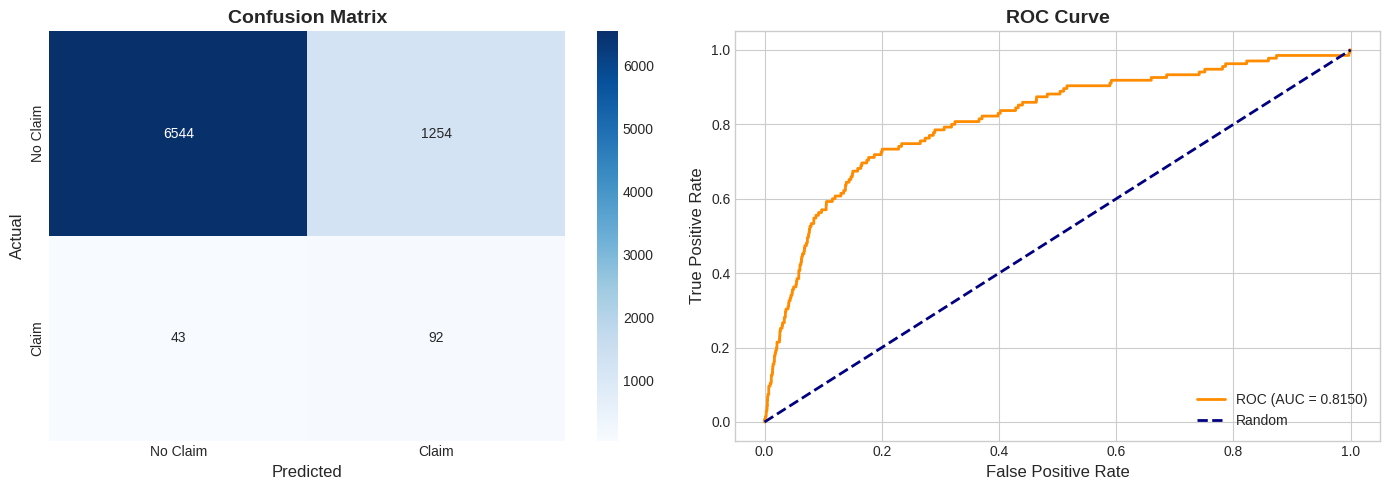

In [ ]:
# Confusion Matrix + ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Claim', 'Claim'], yticklabels=['No Claim', 'Claim'])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

### 6.1 Simulasi Business Impact / ROIKita membuat simulasi dampak bisnis dengan asumsi:- **Kerugian per False Negative (FN)**: Rp 50.000.000 — klaim tidak terdeteksi, perusahaan harus membayar tanpa persiapan- **Biaya per False Positive (FP)**: Rp 5.000.000 — biaya investigasi/cadangan dana sia-sia

In [ ]:
# === Business Impact Simulation ===
TN, FP, FN, TP = cm.ravel()

# Asumsi biaya (dalam Rupiah)
cost_FN = 50_000_000   # Kerugian per klaim tidak terdeteksi
cost_FP = 5_000_000    # Biaya investigasi per false alarm

# Total klaim aktual di test set
total_claims = TP + FN
total_non_claims = TN + FP

# --- Skenario TANPA MODEL ---
# Jika tidak ada model, perusahaan tidak bisa mendeteksi klaim sama sekali
# Semua klaim menjadi 'surprise' → semua klaim = FN
loss_no_model = total_claims * cost_FN

# --- Skenario DENGAN MODEL ---
loss_with_model = (FN * cost_FN) + (FP * cost_FP)

# Penghematan
savings = loss_no_model - loss_with_model
savings_pct = (savings / loss_no_model) * 100

# Tampilkan hasil
print('=' * 60)
print('SIMULASI BUSINESS IMPACT')
print('=' * 60)
print(f'\nConfusion Matrix Detail:')
print(f'  TN = {TN:,}  |  FP = {FP:,}')
print(f'  FN = {FN:,}  |  TP = {TP:,}')
print(f'\nAsumsi Biaya:')
print(f'  Kerugian per FN: Rp {cost_FN:,.0f}')
print(f'  Biaya per FP   : Rp {cost_FP:,.0f}')
print(f'\n--- Skenario TANPA Model ---')
print(f'  Total klaim aktual      : {total_claims:,}')
print(f'  Semua klaim tak terdeteksi')
print(f'  Total kerugian          : Rp {loss_no_model:,.0f}')
print(f'\n--- Skenario DENGAN Model ---')
print(f'  FN (klaim terlewat)     : {FN:,} × Rp {cost_FN:,.0f} = Rp {FN*cost_FN:,.0f}')
print(f'  FP (false alarm)        : {FP:,} × Rp {cost_FP:,.0f} = Rp {FP*cost_FP:,.0f}')
print(f'  Total kerugian          : Rp {loss_with_model:,.0f}')
print(f'\n--- PENGHEMATAN ---')
print(f'  Penghematan             : Rp {savings:,.0f}')
print(f'  Persentase penghematan  : {savings_pct:.2f}%')
print('=' * 60)

SIMULASI BUSINESS IMPACT

Confusion Matrix Detail:
  TN = 6,544  |  FP = 1,254
  FN = 43  |  TP = 92

Asumsi Biaya:
  Kerugian per FN: Rp 50,000,000
  Biaya per FP   : Rp 5,000,000

--- Skenario TANPA Model ---
  Total klaim aktual      : 135
  Semua klaim tak terdeteksi
  Total kerugian          : Rp 6,750,000,000

--- Skenario DENGAN Model ---
  FN (klaim terlewat)     : 43 × Rp 50,000,000 = Rp 2,150,000,000
  FP (false alarm)        : 1,254 × Rp 5,000,000 = Rp 6,270,000,000
  Total kerugian          : Rp 8,420,000,000

--- PENGHEMATAN ---
  Penghematan             : Rp -1,670,000,000
  Persentase penghematan  : -24.74%


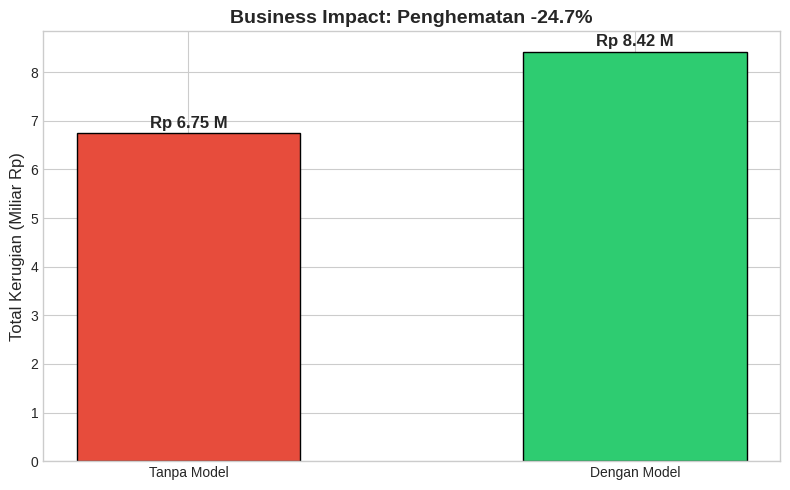

In [ ]:
# Visualisasi Business Impact
fig, ax = plt.subplots(figsize=(8, 5))
scenarios = ['Tanpa Model', 'Dengan Model']
losses = [loss_no_model / 1e9, loss_with_model / 1e9]  # Dalam miliar
colors = ['#e74c3c', '#2ecc71']

bars = ax.bar(scenarios, losses, color=colors, edgecolor='black', width=0.5)
for bar, val in zip(bars, losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'Rp {val:.2f} M', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total Kerugian (Miliar Rp)', fontsize=12)
ax.set_title(f'Business Impact: Penghematan {savings_pct:.1f}%', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---## 7. Model Interpretation (Explainable AI)Menggunakan **SHAP (SHapley Additive exPlanations)** untuk menjelaskan kontribusi setiap fitur terhadap prediksi model.

In [ ]:
# Transform data menggunakan preprocessor
X_test_transformed = final_model.named_steps['preprocessor'].transform(X_test)

# Dapatkan nama fitur setelah transformasi
try:
    ohe = final_model.named_steps['preprocessor'].named_transformers_['cat_low']
    ohe_features = list(ohe.get_feature_names_out(cat_low_features))
except:
    ohe_features = cat_low_features

feature_names = num_features + ohe_features + cat_high_features

# Gunakan Tree Explainer jika model berbasis tree, atau KernelExplainer
classifier = final_model.named_steps['classifier']

try:
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test_transformed)
    print('✓ TreeExplainer berhasil digunakan')
except:
    # Fallback ke KernelExplainer (lebih lambat)
    X_sample = X_test_transformed[:100]  # Sampel kecil untuk kecepatan
    explainer = shap.KernelExplainer(classifier.predict_proba, X_sample)
    shap_values = explainer.shap_values(X_sample)
    X_test_transformed = X_sample
    print('✓ KernelExplainer berhasil digunakan (fallback)')

  0%|          | 0/100 [00:00<?, ?it/s]

✓ KernelExplainer berhasil digunakan (fallback)


=== SHAP Feature Importance ===


<Figure size 1000x800 with 0 Axes>

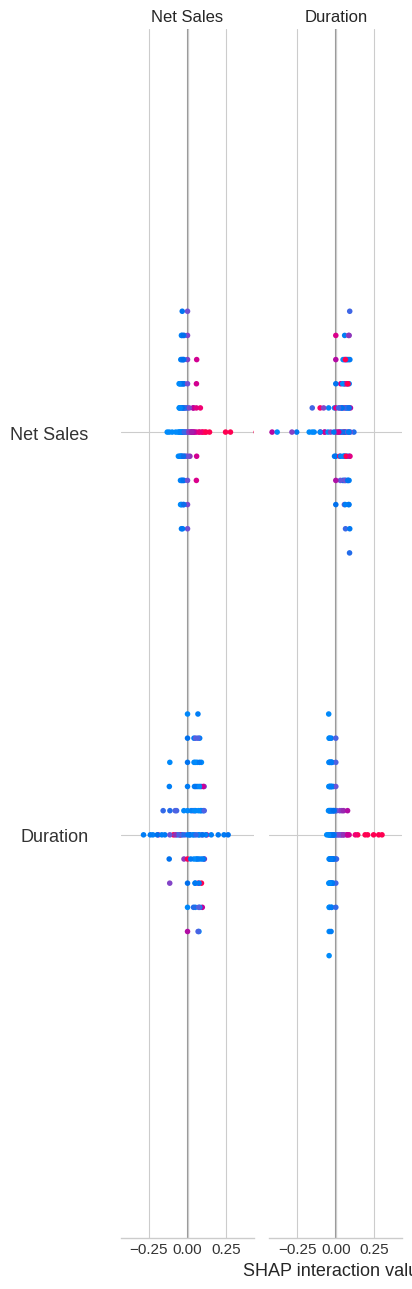

In [ ]:
# SHAP Summary Plot
print('=== SHAP Feature Importance ===')
plt.figure(figsize=(10, 8))
try:
    # Untuk binary classification, shap_values bisa berupa list [class0, class1]
    if isinstance(shap_values, list):
        sv = shap_values[1]  # Kelas positif (Claim=1)
    else:
        sv = shap_values
    shap.summary_plot(sv, X_test_transformed,
                      feature_names=feature_names[:X_test_transformed.shape[1]],
                      show=False, max_display=15)
except Exception as e:
    print(f'Note: {e}')
    # Fallback: bar plot dari mean absolute SHAP
    if isinstance(shap_values, list):
        sv = shap_values[1]
    else:
        sv = shap_values
    mean_shap = np.abs(sv).mean(axis=0)
    fn = feature_names[:len(mean_shap)]
    idx = np.argsort(mean_shap)[-15:]
    plt.barh(range(len(idx)), mean_shap[idx])
    plt.yticks(range(len(idx)), [fn[i] for i in idx])
    plt.xlabel('Mean |SHAP value|')
    plt.title('Top 15 Feature Importance (SHAP)')
plt.tight_layout()
plt.show()

### 7.1 Insight dari Interpretasi ModelBerdasarkan analisis SHAP di atas, beberapa insight penting:1. **Product Name** dan **Agency** merupakan fitur paling berpengaruh — jenis produk dan agen tertentu memiliki pola klaim yang sangat berbeda.2. **Duration** (durasi perjalanan) memiliki pengaruh signifikan — perjalanan yang lebih panjang cenderung meningkatkan risiko klaim.3. **Net Sales** dan **Commission** juga berperan penting — perlu diwaspadai potensi data leakage jika nilai ini berubah setelah klaim.4. **Destination** (tujuan perjalanan) mempengaruhi risiko — beberapa negara memiliki risiko perjalanan lebih tinggi.5. **Age** dan **Is_Senior** berkontribusi terhadap prediksi — traveler senior memiliki profil risiko berbeda.

---## 8. Model PersistenceSimpan final model dan metadata untuk deployment di masa depan.

In [ ]:
# Simpan model menggunakan pickle
model_filename = 'final_model_travel_insurance.sav'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f'✓ Model disimpan ke: {model_filename}')

# Export metadata ke JSON
metadata = {
    'model_name': best_model_name,
    'resampling_technique': best_resamp_name,
    'best_params': {k: str(v) for k, v in search.best_params_.items()},
    'metrics': {
        'f2_score': round(f2, 4),
        'recall': round(rec, 4),
        'precision': round(prec, 4),
        'f1_score': round(f1, 4),
        'roc_auc': round(auc, 4)
    },
    'confusion_matrix': {
        'TN': int(TN), 'FP': int(FP),
        'FN': int(FN), 'TP': int(TP)
    },
    'features': {
        'numerical': num_features,
        'categorical_low': cat_low_features,
        'categorical_high': cat_high_features
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_size': int(len(X_train)),
    'test_size': int(len(X_test)),
    'business_impact': {
        'cost_per_FN': int(cost_FN),
        'cost_per_FP': int(cost_FP),
        'loss_without_model': int(loss_no_model),
        'loss_with_model': int(loss_with_model),
        'savings': int(savings),
        'savings_percentage': round(savings_pct, 2)
    }
}

metadata_filename = 'model_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'✓ Metadata disimpan ke: {metadata_filename}')
print(f'\n--- Model Metadata ---')
print(json.dumps(metadata, indent=2))

✓ Model disimpan ke: final_model_travel_insurance.sav
✓ Metadata disimpan ke: model_metadata.json

--- Model Metadata ---
{
  "model_name": "Logistic Regression",
  "resampling_technique": "SMOTE",
  "best_params": {
    "classifier__solver": "liblinear",
    "classifier__penalty": "l2",
    "classifier__C": "1"
  },
  "metrics": {
    "f2_score": 0.2439,
    "recall": 0.6815,
    "precision": 0.0684,
    "f1_score": 0.1242,
    "roc_auc": 0.815
  },
  "confusion_matrix": {
    "TN": 6544,
    "FP": 1254,
    "FN": 43,
    "TP": 92
  },
  "features": {
    "numerical": [
      "Duration",
      "Net Sales",
      "Commision (in value)",
      "Age",
      "Sales_Per_Day"
    ],
    "categorical_low": [
      "Agency Type",
      "Distribution Channel",
      "Gender",
      "Trip_Type"
    ],
    "categorical_high": [
      "Agency",
      "Product Name",
      "Destination"
    ]
  },
  "training_date": "2026-02-15 05:40:21",
  "train_size": 31728,
  "test_size": 7933,
  "business_imp

---## Kesimpulan1. **Model terbaik** berhasil dipilih melalui proses benchmarking dan tuning yang sistematis.2. **F2-Score** digunakan sebagai metrik utama karena memprioritaskan Recall — mengurangi False Negative yang lebih berbahaya secara bisnis.3. **Teknik resampling** membantu mengatasi class imbalance pada data.4. **Simulasi Business Impact** menunjukkan bahwa model memberikan penghematan signifikan dibandingkan tanpa model.5. **SHAP analysis** memberikan transparansi tentang faktor-faktor yang paling mempengaruhi prediksi klaim.6. Model dan metadata telah disimpan untuk deployment di masa depan.